### GIven a datetime, download EUV data from STEREO A, SDO (and STEREO B if available), project to Heliographic Carrington, blend.

In [1]:
import numpy as np 
import astropy.units as u 
import matplotlib.pyplot as plt  
from astropy.coordinates import SkyCoord,cartesian_to_spherical   
import sunpy.map 
from sunpy.coordinates import frames 
from sunpy.data.sample import AIA_171_IMAGE    
from sunpy.time import parse_time
from scipy.interpolate import griddata
import sunpy.coordinates
import sunpy.coordinates.wcs_utils
from sunpy.net import Fido, attrs as a
from datetime import datetime,timedelta
import warnings

### First, try a test case with sunpy sample data

In [5]:
# Example map with sunpy sample data
aia = sunpy.map.Map(AIA_171_IMAGE) 

# Crop to full disk
aia_crop = aia.submap(SkyCoord([-1100, 1100]*u.arcsec,
                                [-1100, 1100]*u.arcsec,
                                frame=aia.coordinate_frame))


# Resample to smaller size
resample_size=None
if isinstance(resample_size,int) : aia_crop=aia_crop.resample(u.Quantity([resample_size,resample_size]*u.pixel))

In [ ]:
# Get data as ndarray
aia_dat = aia_crop.data

# Parse obs time to datetime
date_obs=aia_crop.observer_coordinate.frame.obstime.value
dt_obs = parse_time(date_obs).datetime

# Generate array of helioprojective coordinates describing pixel locations
ref_skycoord = aia_crop.reference_coordinate
ref_pix_x,ref_pix_y = (aia_crop.reference_pixel.x,
                       aia_crop.reference_pixel.y
                      )
deltx,delty=aia_crop.scale.axis1,aia_crop.scale.axis2
xarr = ((np.arange(aia_dat.shape[1])*u.pix-ref_pix_x)*deltx 
        + ref_skycoord.Tx)
yarr = ((np.arange(aia_dat.shape[0])*u.pix-ref_pix_y)*delty 
        + ref_skycoord.Ty)
coords_raw_x,coords_raw_y = np.meshgrid(xarr,yarr)
helioproj_pixel_coords = SkyCoord(coords_raw_x.flatten(),
                                  coords_raw_y.flatten(),
                                  frame=aia_crop.coordinate_frame)

# Transform pixel coordinates to heliographic stonyhurst and carrington coordinates. 
# Then Generate list of longitudes and latitudes corresponding to pixels in original data
# Throws warningsb because of Nan values
heeq_pixel_coords=helioproj_pixel_coords.transform_to(frames.HeliographicStonyhurst)
carr_pixel_coords=helioproj_pixel_coords.transform_to(frames.HeliographicCarrington)
heeq_pixel_coords.representation_type="cartesian"
carr_pixel_coords.representation_type="cartesian"
heeq_x,heeq_y,heeq_z=heeq_pixel_coords.x,heeq_pixel_coords.y,heeq_pixel_coords.z
carr_x,carr_y,carr_z=carr_pixel_coords.x,carr_pixel_coords.y,carr_pixel_coords.z
_,lat_heeq,lon_heeq = cartesian_to_spherical(heeq_x,heeq_y,heeq_z)
_,lat_carr,lon_carr = cartesian_to_spherical(carr_x,carr_y,carr_z)

In [ ]:
# Sanity check the coordinate conversions by generating a mask of all pixels
# whose coordinates transform to real heliographic coordinates (i.e. not NaN)
# The only coordinates with Nan values should lie outside the solar disk
lat_carr_grid = lat_carr.reshape(aia_dat.shape)
lon_carr_grid = lon_carr.reshape(aia_dat.shape)
lat_heeq_grid = lat_heeq.reshape(aia_dat.shape)
lon_heeq_grid = lon_heeq.reshape(aia_dat.shape)
plt.figure(figsize=(10,10))
ax1=plt.subplot(221)
ax1.set_aspect(1)
mask1 = np.zeros(aia_dat.shape)
mask1[~np.isnan(lat_carr_grid)]=1
plt.pcolormesh(xarr,yarr,aia_dat*mask1,vmin=0,vmax=1000)
plt.title("Carrington, not Nan Heliographic Pixels")
ax2=plt.subplot(222)
ax2.set_aspect(1)
mask2 = np.zeros(aia_dat.shape)
mask2[~np.isnan(lat_heeq_grid)]=1
plt.pcolormesh(xarr,yarr,aia_dat*mask2,vmin=0,vmax=1000)
plt.title("Stonyhurst, not Nan Heliographic Pixels")
ax3=plt.subplot(223)
ax3.set_aspect(1)
mask3 = np.zeros(aia_dat.shape)
mask3[np.isnan(lat_carr_grid)]=1
plt.pcolormesh(xarr,yarr,aia_dat*mask3,vmin=0,vmax=1000)
plt.title("Carrington, Nan Heliographic Pixels")
ax4=plt.subplot(224)
ax4.set_aspect(1)
mask4 = np.zeros(aia_dat.shape)
mask4[np.isnan(lat_heeq_grid)]=1
plt.pcolormesh(xarr,yarr,aia_dat*mask4,vmin=0,vmax=1000)
plt.title("Stonyhurst, Nan Heliographic Pixels")

In [ ]:
### The quick way : python tripcolor can plot irregular gridded data 
### using triangular patches and interpolating.
raster=20
fig,[ax1,ax2]=plt.subplots(ncols=2,figsize=(20,6))
ax1.tripcolor(np.degrees(lon_carr[~np.isnan(lon_carr)][::raster]),
              np.degrees(lat_carr[~np.isnan(lon_carr)][::raster]),
              aia_dat.flatten()[~np.isnan(lon_carr)][::raster],
              vmin=0,vmax=5000,cmap='sdoaia171')
ax1.set_xlim([0,360])
ax1.set_ylim([-90,90])
ax1.set_title("Carrington Coordinates - tripcolor")
ax1.set_aspect(1)
L0=sunpy.coordinates.sun.L0(dt_obs).value
ax1.axvline(L0,linewidth=5,color="blue")
ax1.text(L0,-100,"L0",fontsize=20,bbox=dict(facecolor="white"),
         horizontalalignment='center')

lons_stonyhurst=np.array([deg-360. if deg > 180 else deg 
                          for deg in np.degrees(lon_heeq[~np.isnan(lon_heeq)]).value])
ax2.tripcolor(lons_stonyhurst[::raster],
              np.degrees(lat_heeq[~np.isnan(lon_heeq)][::raster]),
              aia_dat.flatten()[~np.isnan(lon_heeq)][::raster],
              vmin=0,vmax=5000,cmap='sdoaia171')
ax2.set_xlim([-180,180])
ax2.set_ylim([-90,90])
ax2.set_title("Stonyhurst Coordinates - tripcolor")
ax2.set_aspect(1)
ax2.axvline(0,linewidth=5,color="blue")
ax2.text(0,-100,"L0",fontsize=20,bbox=dict(facecolor="white"),
         horizontalalignment='center')

In [ ]:
### The more robust way :
### Interpolate irregularly gridded data to a uniform grid in lat and lon

# Define interpolated grid
lat_interp = np.linspace(-np.radians(90),np.radians(90),360)
lon_interp = np.radians(np.linspace(0,360,720))

# We do this in stony hurst coordinates but shift the 0 point to 180 degrees to the whole image
# is in the positive longitude range. We shift to carrington frame at the end.
lon=((lon_heeq[~np.isnan(lon_heeq)]+np.radians(180)*u.rad) % (np.radians(360)*u.rad)).value
lat=lat_heeq[~np.isnan(lon_heeq)].value # Remove nan data points (breaks interpolator)
points = np.array([lon,lat]).T
values = aia_dat.flatten()[~np.isnan(lon_heeq)]
out_mesh = np.meshgrid(lon_interp,lat_interp)

#Perform interpolation
aia_interp = griddata(points,values,tuple(out_mesh),method='linear')

# Restore flattened data to 2d array with dimensions
# of interpolated grid.
aia_interp=aia_interp.reshape(out_mesh[0].shape)

In [ ]:
# Correct to carrington coords
L0 = sunpy.coordinates.sun.L0(dt_obs).value # Carrington coordinate of sub-earth point
lon_corrected = ((np.degrees(lon_interp)-180)+L0)%360 #shift and enforce [0:360] range
sort_inds = np.argsort(lon_corrected) # Get indices of lon values when lons are ordered to ascend
lon_corrected = np.sort(lon_corrected) # order lons in ascending order
aia_interp = aia_interp[:,sort_inds]# order EUV data by ascending longitude

#Plot
fig,ax=plt.subplots(figsize=(20,10))
plt.pcolormesh(lon_corrected,np.degrees(lat_interp),aia_interp,vmin=0,vmax=5000,cmap='sdoaia171')
ax.set_aspect(1)

In [76]:
### Define function to repeat this work with the mapping:
# Input: sunpy.map.Map instance -> [carrington lons,carrington lats, interpolated map data]
def get_carr_map(sunpymap,nlon=720,nlat=360,interp_mode="linear",resample_size=None) :
    if not isinstance(sunpymap,sunpy.map.map_factory.GenericMap) : return "Input must be sunpy map instance (sunpy.map.map_factory.GenericMap)"
    
    # Crop to full disk
    map_crop = sunpymap.submap(SkyCoord([-1100, 1100]*u.arcsec,
                                        [-1100, 1100]*u.arcsec,
                                        frame=sunpymap.coordinate_frame))

    # If resample_size arg passed (integer), resample map to (resample_size,resample_size)
    if isinstance(resample_size,int) : map_crop=map_crop.resample(u.Quantity([resample_size,resample_size]*u.pixel))
    
    # Get data as ndarray
    map_dat = map_crop.data

    # Map Central Longitude (stonyhurst)
    M0=map_crop.coordinate_frame.observer.lon.value % 360
    
    # Parse obs time to datetime
    date_obs=map_crop.observer_coordinate.frame.obstime.value
    dt_obs = parse_time(date_obs).datetime

    # Generate array of helioprojective coordinates describing pixel locations
    ref_skycoord = map_crop.reference_coordinate
    ref_pix_x,ref_pix_y = (map_crop.reference_pixel.x,
                           map_crop.reference_pixel.y
                          )
    deltx,delty=map_crop.scale.axis1,map_crop.scale.axis2
    xarr = ((np.arange(map_dat.shape[1])*u.pix-ref_pix_x)*deltx 
            + ref_skycoord.Tx)
    yarr = ((np.arange(map_dat.shape[0])*u.pix-ref_pix_y)*delty 
            + ref_skycoord.Ty)
    coords_raw_x,coords_raw_y = np.meshgrid(xarr,yarr)
    helioproj_pixel_coords = SkyCoord(coords_raw_x.flatten(),
                                      coords_raw_y.flatten(),
                                      frame=map_crop.coordinate_frame)

    # Transform pixel coordinates to heliographic stonyhurst and carrington coordinates. 
    # Then Generate list of longitudes and latitudes corresponding to pixels in original data
    # Throws warningsb because of Nan values
    heeq_pixel_coords=helioproj_pixel_coords.transform_to(frames.HeliographicStonyhurst)
    lat_heeq = heeq_pixel_coords.data.lat
    lon_heeq = heeq_pixel_coords.data.lon
    
    ### Interpolate irregularly gridded data to a uniform grid in lat and lon

    # Define interpolated grid
    lat_interp = np.linspace(-np.radians(90),np.radians(90),nlat)
    lon_interp = np.radians(np.linspace(0,360,nlon))

    # We do this in stony hurst coordinates but shift the 0 point to 180 degrees to the whole image
    # is in the positive longitude range. We shift to carrington frame at the end.
    lon=((lon_heeq[~np.isnan(lon_heeq)]+np.radians(180)*u.rad) % (np.radians(360)*u.rad)).value
    lat=lat_heeq[~np.isnan(lon_heeq)].value # Remove nan data points (breaks interpolator)
    points = np.array([lon,lat]).T
    values = map_dat.flatten()[~np.isnan(lon_heeq)]
    out_mesh = np.meshgrid(lon_interp,lat_interp)

    #Perform interpolation
    map_interp = griddata(points,values,tuple(out_mesh),method=interp_mode)

    # Restore flattened data to 2d array with dimensions
    # of interpolated grid.
    map_interp=map_interp.reshape(out_mesh[0].shape)  
    
    # Make NaN all data outside +/-60 deg of observation center
    map_interp[:,]
    
    # Correct to carrington coords
    L0 = sunpy.coordinates.sun.L0(dt_obs).value # Carrington coordinate of sub-earth point
    lon_corrected = ((np.degrees(lon_interp)-180)+L0)%360 #shift and enforce [0:360] range
    sort_inds = np.argsort(lon_corrected) # Get indices of lon values when lons are ordered to ascend
    lon_corrected = np.sort(lon_corrected) # order lons in ascending order
    map_interp = map_interp[:,sort_inds]# order EUV data by ascending longitude
    
    # Throw away data greater than 60 deg from lon center
    M0_carr = (M0+L0)%360
    if (M0_carr-60 >= 0) and (M0_carr + 60 <= 360) : 
        naninds = np.where((lon_corrected < M0_carr-60)
                            | (lon_corrected > M0_carr+60)
                          )[0]
    else :
        naninds = np.where((lon_corrected > ((M0_carr+60) % 360))
                            & (lon_corrected < ((M0_carr-60)%360))
                          )[0]
    map_interp[:,naninds]=np.nan
    
    return lon_corrected,np.degrees(lat_interp),map_interp

def plot_carr_map(lons,lats,values,sunpymaps=None,pcmax=100,pcmin=0,
                  cmap='sdoaia193',figax=None,sinelat=False):
    #Plot
    if sunpymaps is not None : date_obs=sunpymaps[0].observer_coordinate.frame.obstime.value
    if figax is None : fig,ax=plt.subplots(figsize=(20,10))
    else : fig,ax=figax
    if sinelat : 
        ax.pcolormesh(lons,np.sin(np.radians(lats)),values,vmin=np.nanpercentile(values,pcmin),
                       vmax=np.nanpercentile(values,pcmax),cmap=cmap)
        ax.set_aspect(90)
        ax.set_ylabel("Sine(Carrington Latitude)",fontsize=18)
    else : 
        ax.pcolormesh(lons,lats,values,vmin=np.nanpercentile(values,pcmin),
                        vmax=np.nanpercentile(values,pcmax),cmap=cmap)
        ax.set_aspect(1)
        ax.set_ylabel("Carrington Latitude / Deg",fontsize=18)
    ax.set_xlabel("Carrington Longitude / Deg",fontsize=18)
    
    if sunpymaps is not None : ax.set_title(f"{date_obs} {[(sunpymap.observatory,sunpymap.instrument) for sunpymap in sunpymaps]}",fontsize=18)

In [13]:
# Test function :
map_=maps[0]
lon,lat,values=get_carr_map(map_,resample_size=1024)

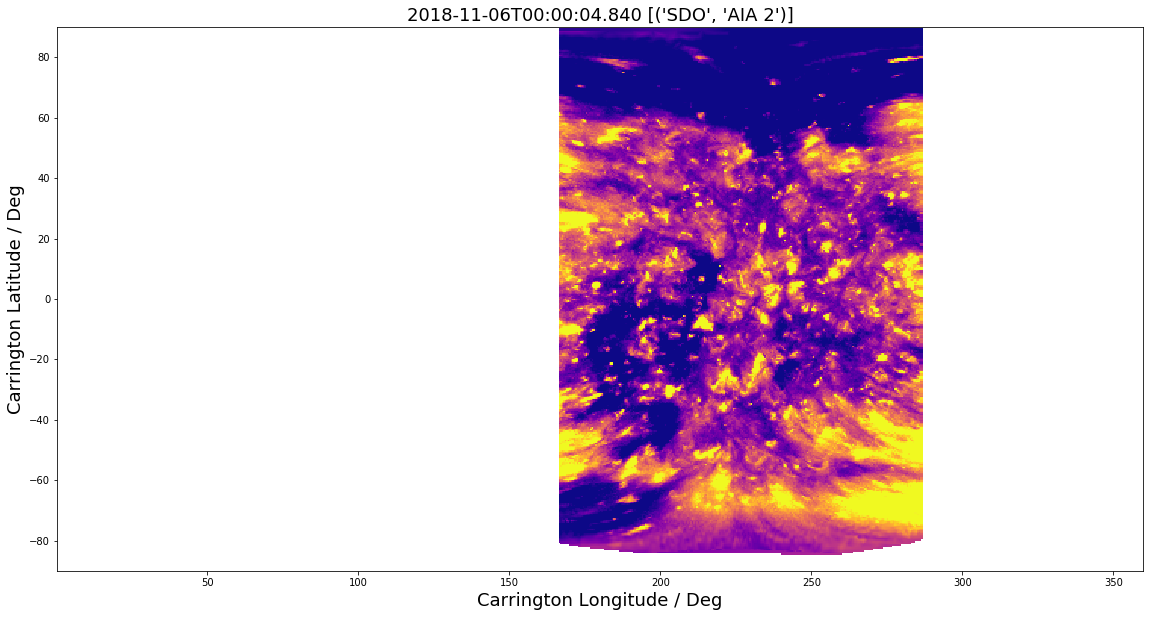

In [14]:
# Plot
plot_carr_map(lon,lat,values,[map_],pcmin=20,pcmax=95,cmap='plasma')

### Next step : For a given date, download a STEREO A and SDO EUV image and superpose the deprojections

In [7]:
import matplotlib.pyplot as plt

import astropy.units as u
from astropy.coordinates import SkyCoord

import sunpy.map
import sunpy.coordinates
import sunpy.coordinates.wcs_utils
from sunpy.net import Fido, attrs as a
from datetime import datetime,timedelta

dt = datetime(2018,11,6)
def time_string(dt) : return f"{dt.year}-{dt.month:02d}-{dt.day:02d}T{dt.hour:02d}:{dt.minute:02d}:{dt.second:02d}"

stereo = (a.vso.Source('STEREO_A') &
          a.Instrument('EUVI') &
          a.Time(time_string(dt), time_string(dt+timedelta(minutes=60)))
         )

aia = (a.Instrument('AIA') &
       a.Time(time_string(dt), time_string(dt+timedelta(minutes=60)))
      )

wave = a.Wavelength(19 * u.nm, 20 * u.nm)


res = Fido.search(wave, aia | stereo)

files = Fido.fetch(res[:,0])

In [8]:
maps = [m for m in sunpy.map.Map(files)]

In [ ]:
carrmaps = [get_carr_map(map_) for map_ in maps]

In [ ]:
lons,lats=carrmaps[0][0:2]

# Quick process maps to have same floor value (0) and same median
quick_proc_1 = carrmaps[0][2]-np.nanmin(carrmaps[0][2])
quick_proc_1 /= np.nanmedian(quick_proc_1)
quick_proc_2 = carrmaps[1][2]-np.nanmin(carrmaps[1][2])
quick_proc_2 /= np.nanmedian(quick_proc_2)                                        

combined = np.nanmean(np.array([quick_proc_1,quick_proc_2]), axis=0)
plot_carr_map(lons,lats,combined,maps[1],pcmin=20,pcmax=95,cmap='sdoaia193')

In [ ]:
# Visualize impact on distribution
plt.subplot(121)
plt.title("Raw")
_=plt.hist(carrmaps[0][2].flatten(),np.linspace(0,2000,100),color="blue")
_=plt.hist(carrmaps[1][2].flatten(),np.linspace(0,2000,100),color="red",alpha=0.5)
plt.subplot(122)
plt.title("Processed")
_=plt.hist(quick_proc_1.flatten(),np.linspace(0,5,100),color="blue")
_=plt.hist(quick_proc_2.flatten(),np.linspace(0,5,100),color="red",alpha=0.5)
plt.tight_layout()

### Wrapper from datetime to carrington map

In [20]:
def time_string(dt) : return f"{dt.year}-{dt.month:02d}-{dt.day:02d}T{dt.hour:02d}:{dt.minute:02d}:{dt.second:02d}"

def download_and_gen_carrmap(dt,resample_size=None) :
    stereoA = (a.vso.Source('STEREO_A') &
              a.Instrument('EUVI') &
              a.Time(time_string(dt), time_string(dt+timedelta(minutes=60)))
             )
    stereoB = (a.vso.Source('STEREO_B') &
              a.Instrument('EUVI') &
              a.Time(time_string(dt), time_string(dt+timedelta(minutes=60)))
             ) 
    aia = (a.Instrument('AIA') &
           a.Time(time_string(dt), time_string(dt+timedelta(minutes=60)))
          )
    wave = a.Wavelength(19 * u.nm, 20 * u.nm)
    res = Fido.search(wave, aia | stereoA | stereoB)
    files=[]
    for jj in range(len(res)) :
        try : files.append(Fido.fetch(res[jj,0]))
        except : ""

    maps = [m for m in sunpy.map.Map(files)]
    carrmaps = [get_carr_map(map_,resample_size=resample_size) for map_ in maps]

    lons,lats=carrmaps[0][0:2]

    # Quick process maps to have same floor value (0) and same median
    quick_procs_list=[]
    for arr in carrmaps[:] :
        arr=arr[2]
        quick_proc = arr-np.nanmin(arr)
        quick_procs_list.append(quick_proc/np.nanmedian(quick_proc))
                                   
    combined = np.nanmean(np.array(quick_procs_list), axis=0)
    
    return lons,lats,combined,maps
    
#coord_ref = SkyCoord(0*u.deg,180*u.deg,obstime=time_string(dt),
#                     observer='earth',frame=frames.HeliographicCarrington)

#xpix = combined.shape[1]/2.
#ypix = combined.shape[0]/2.

#header = sunpy.map.header_helper.make_fitswcs_header(combined.T, coord_ref,
#                                                     reference_pixel=u.Quantity([ypix, xpix]*u.pixel),
#                                                     scale=u.Quantity([360./combined.shape[1], 
#                                                                       180./combined.shape[0]]*u.degree/u.pixel),
#                                                     telescope=f'{[map_.observatory for map_ in maps]}', 
#                                                     instrument=f'{[map_.instrument for map_ in maps]}',
#                                                     wavelength=maps[0].wavelength 
#                                                    )

In [60]:
dt=datetime(2018,10,31)
lon,lat,combined,maps=download_and_gen_carrmap(dt,resample_size=512)

/home/samuel_badman/anaconda3/lib/python3.7/site-packages/astropy/coordinates/distances.py:183: RuntimeWarning: invalid value encountered in less
  if not allow_negative and np.any(distance.value < 0):
/home/samuel_badman/anaconda3/lib/python3.7/site-packages/astropy/coordinates/angles.py:642: RuntimeWarning: invalid value encountered in less
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/home/samuel_badman/anaconda3/lib/python3.7/site-packages/astropy/coordinates/angles.py:529: RuntimeWarning: invalid value encountered in less
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/home/samuel_badman/anaconda3/lib/python3.7/site-packages/astropy/coordinates/angles.py:529: RuntimeWarning: invalid value encountered in greater
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/home/samuel_badman/anaconda3/lib/python3.7/site-packages/astropy/coordinates/angles.py:642: RuntimeWarning: invalid value encountered in greater_equal


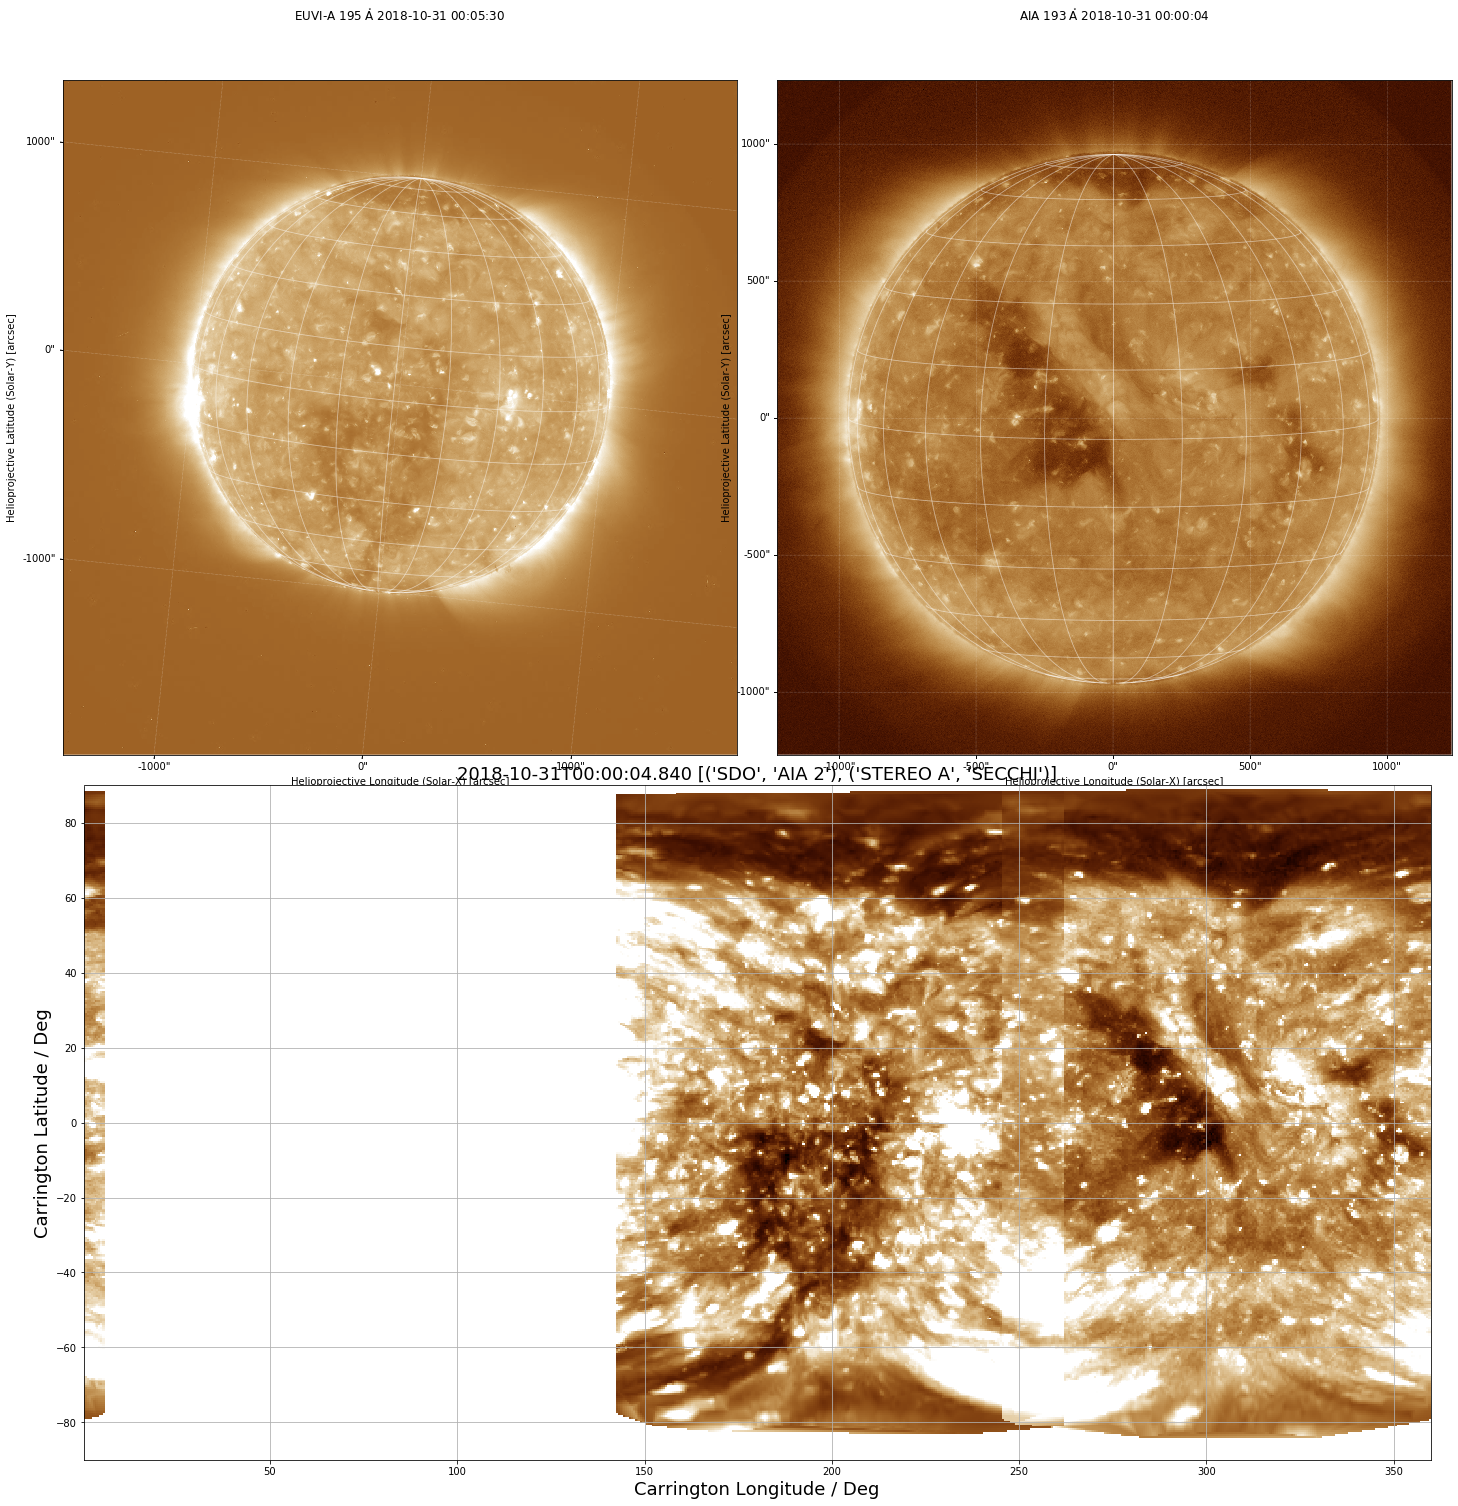

In [93]:
fig=plt.figure(figsize=(20,20))

def get_M0(map_) : return map_.coordinate_frame.observer.lon.value % 360

warnings.filterwarnings('ignore')

int_init=201
int_init += 10*len(maps)
share=False
ax1=plt.subplot(int_init)
for map_ in sorted(maps,key=get_M0):
    ax=plt.subplot(int_init,projection=map_)
    crop = map_#map_.submap(SkyCoord([-1100, 1100]*u.arcsec,
               #                 [-1100, 1100]*u.arcsec,
               #                 frame=map_.coordinate_frame))
    pl=crop.plot(cmap='sdoaia193',vmax=2000)
    crop.draw_grid()
    int_init += 1
    
ax_carr = plt.subplot(212)
plot_carr_map(lon,lat,combined,maps,pcmax=90,figax=(fig,ax_carr),sinelat=False)
plt.grid()

plt.tight_layout()

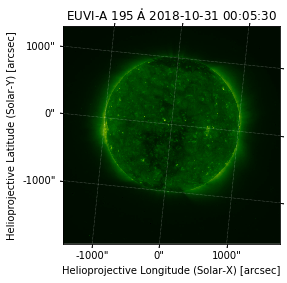

In [66]:
maps[1].plot()

In [64]:
m=maps[1]
m??